In [111]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [115]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
    

    

In [116]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50


In [117]:
inputs = Input(shape = input_shape, name = "encoder_input")
x = Dense(intermediate_dim, activation = "relu")(inputs)
z_mean = Dense(latent_dim, name = "z_mean")(x)
z_log_var = Dense(latent_dim, name = "z_log_var")(x)

# reparameterization trick to push smapling out
z = Lambda(sampling, output_shape = (latent_dim, ), name = "z")([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name = "encoder")
print(encoder.summary())
plot_model(encoder, to_file = "models/vae_mnist_encoder.png", show_shapes = True, show_layer_names = True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_66[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_66[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [118]:
latent_inputs = Input(shape = (latent_dim, ), name = "z_sampling")
x = Dense(intermediate_dim, activation = "relu")(latent_inputs)
outputs = Dense(original_dim, activation = "sigmoid")(x)

decoder = Model(latent_inputs, outputs, name = "decoder")
print(decoder.summary())
plot_model(decoder, to_file = "models/vae_mnist_decoder.png", show_shapes = True, show_layer_names = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_68 (Dense)             (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name = "vae_mnist")
print(vae.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = binary_crossentropy(x, x_decoded_mean)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

vae.compile(optimizer = "adam", loss = vae_loss)
print(vae.summary())
plot_model(vae, to_file = "models/vae_mnist.png", show_layer_names = True, show_shapes = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
vae.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 27s 450us/step - loss: 196.2172 - val_loss: 172.0176
Epoch 2/50
60000/60000 [==============================] - 25s 415us/step - loss: 169.8156 - val_loss: 167.2001
Epoch 3/50
60000/60000 [==============================] - 27s 453us/step - loss: 165.9969 - val_loss: 163.9527
Epoch 4/50
60000/60000 [==============================] - 27s 455us/step - loss: 163.3646 - val_loss: 161.5799
Epoch 5/50
60000/60000 [==============================] - 16s 260us/step - loss: 161.2280 - val_loss: 160.3881
Epoch 6/50
60000/60000 [==============================] - 13s 213us/step - loss: 159.6956 - val_loss: 159.0551
Epoch 7/50
60000/60000 [==============================] - 13s 223us/step - loss: 158.4713 - val_loss: 158.2465
Epoch 8/50
60000/60000 [==============================] - 13s 217us/step - loss: 157.4996 - val_loss: 157.2004
Epoch 9/50
60000/60000 [==============================] - 13s 

## Dimensionality Reduction

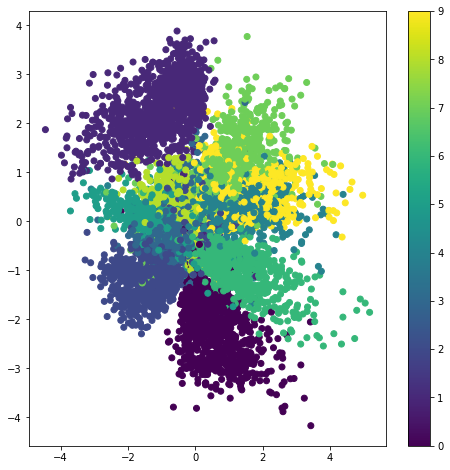

In [124]:
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)[2]
plt.figure(figsize = (8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = y_test)
plt.colorbar()
plt.show()

## Generative Modeling


In [154]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)


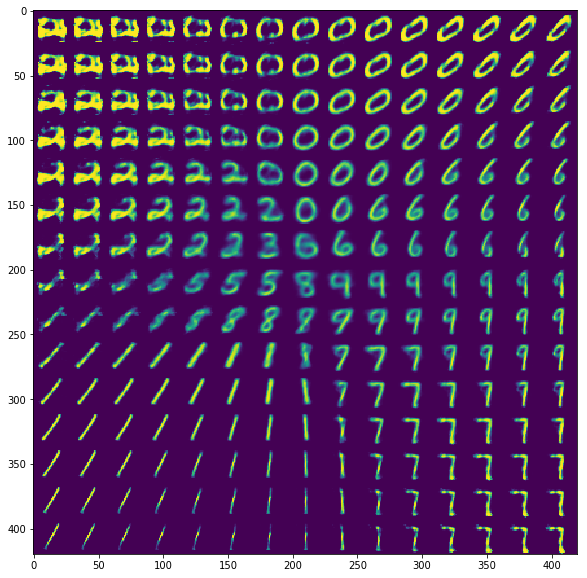

In [155]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit    
        
plt.figure(figsize = (10, 10))
plt.imshow(figure)
plt.show()

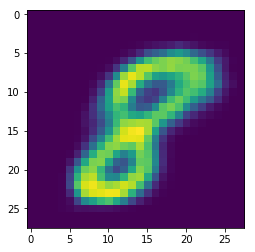

In [140]:
plt.imshow(decoder.predict(np.array([[-1, 0.5]])).reshape(28, 28))